# Imports

In [56]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import keras_tuner as kt

np.random.seed(42)
tf.random.set_seed(42)

Load dataset and split into train, test and validation sets

In [17]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist

#X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
#X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)


In [18]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
"Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Build the search grid and return the model that the oracle selects

In [57]:
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=4, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    momentum = hp.Float("momentum", 0.9, 0.99, default=0.9)
    weight_decay = hp.Float("weight_decay", min_value=1e-6, max_value=1e-2, sampling="log", default=1e-5)

    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True, clipnorm=1.0)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0, use_ema=True, ema_momentum=momentum, weight_decay=weight_decay)
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Rescaling(scale=1./255))
    model.add(tf.keras.layers.Flatten())

    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(
            n_neurons,
            kernel_initializer=tf.keras.initializers.HeNormal(seed=42),
            use_bias=False)),
        model.add(tf.keras.layers.BatchNormalization()),
        model.add(tf.keras.layers.Activation("relu"))
    
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy",
                    optimizer=optimizer,
                    metrics=["accuracy"])
    return model

Run the random grid search using def build_model(), optimizing for validation loss

In [58]:
es_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1,
    min_delta=1e-4
)

random_search_tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=10,
    overwrite=True,
    directory="fashion_mnist",
    project_name="rnd_search",
    seed=42)

random_search_tuner.search(
    X_train,
    y_train,
    epochs=100,
    callbacks=[es_cb],
    validation_data=(X_valid, y_valid))


Trial 10 Complete [00h 01m 11s]
val_loss: 0.34256604313850403

Best val_loss So Far: 0.34256604313850403
Total elapsed time: 00h 03m 25s


Check which hyperparameters yielded the best results

In [59]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()
print("val_accuracy :", best_trial.metrics.get_last_value("val_accuracy"))

Trial 09 summary
Hyperparameters:
n_hidden: 2
n_neurons: 62
learning_rate: 0.0005161743428272905
optimizer: sgd
momentum: 0.9131102329593718
weight_decay: 0.00021115848140850182
Score: 0.34256604313850403
val_accuracy : 0.8775833249092102


In [60]:
best_hps = random_search_tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

best_model = build_model(best_hps)

history = best_model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[es_cb]
)

{'n_hidden': 2, 'n_neurons': 62, 'learning_rate': 0.0005161743428272905, 'optimizer': 'sgd', 'momentum': 0.9131102329593718, 'weight_decay': 0.00021115848140850182}
Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 778us/step - accuracy: 0.6884 - loss: 0.9754 - val_accuracy: 0.7925 - val_loss: 0.6180
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 894us/step - accuracy: 0.7975 - loss: 0.5986 - val_accuracy: 0.8249 - val_loss: 0.5036
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 646us/step - accuracy: 0.8182 - loss: 0.5235 - val_accuracy: 0.8382 - val_loss: 0.4588
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 669us/step - accuracy: 0.8302 - loss: 0.4847 - val_accuracy: 0.8457 - val_loss: 0.4339
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 689us/step - accuracy: 0.8393 - loss: 0.4588 - val_accuracy: 0.8504 - val_loss: 0.4160
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step - accuracy: 0.8459 - loss: 0.4391 - val_accuracy: 0.8535 - val_loss: 0.4034
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━

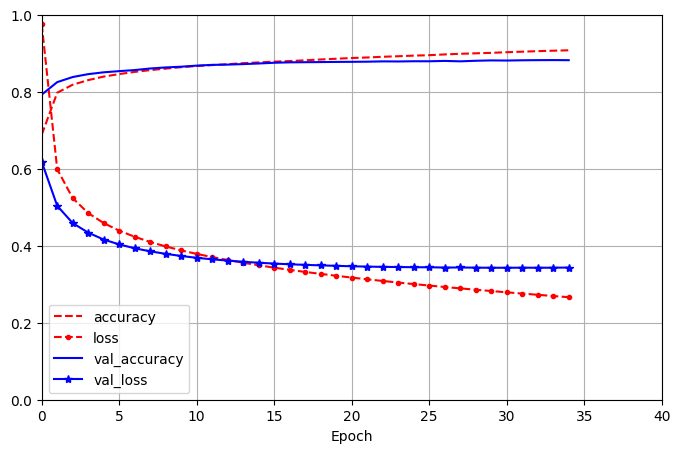

In [61]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 40], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.show()

Initialize the weights using He-initiliazation, suitable for the ReLU activation function because it compensates for the dying ReLU problem

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


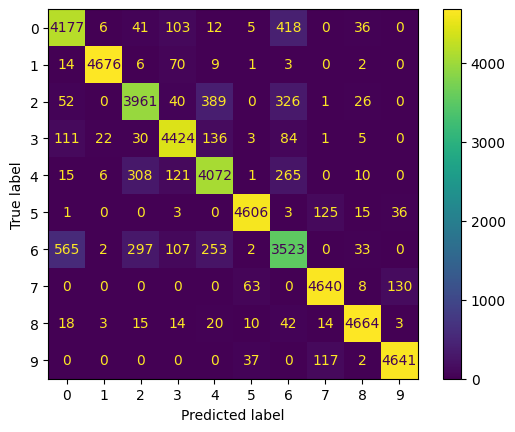

In [62]:
y_prediction_proba = best_model.predict(X_valid)
y_prediction = y_prediction_proba.argmax(axis=1)
predictions_proba = best_model.predict(X_train)
predictions = predictions_proba.argmax(axis=1)
ConfusionMatrixDisplay.from_predictions(y_train, predictions)
plt.show()

In [64]:
best_model.evaluate(X_valid, y_valid)

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - accuracy: 0.8813 - loss: 0.3428


[0.3428152799606323, 0.8813333511352539]

In [66]:
best_model.save("best_so_far.keras")

In [67]:
best_model_so_far = tf.keras.models.load_model("best_so_far.keras")

In [68]:
best_model_so_far.evaluate(X_valid, y_valid)

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.8813 - loss: 0.3428


[0.3428152799606323, 0.8813333511352539]